![](img/573_banner.png)

# Lecture 6: L2- and L1-Regularization

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar 

Atrribution: A lot of this material is adapted from [CPSC 340](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf) lecture notes. 

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")
%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import pandas as pd
from plotting_functions import *
from sklearn import datasets
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
pd.set_option("display.max_colwidth", 200)

### Learning outcomes 

From this lecture, students are expected to be able to: 

- Broadly explain L2 regularization (Ridge).  
- Use L2 regularization (Ridge) using `sklearn`. 
- Compare L0- and L2-regularization.
- Explain the relation between the size of regression weights, overfitting, and complexity hyperparameters. 
- Explain the effect of training data size and effect of regularization.   
- Explain the general idea of L1-regularization.
- Learn to be skeptical about interpretation of the coefficients. 
- Use L1-regularization (Lasso) using `sklearn`. 
- Discuss sparsity in L1-regularization. 
- Compare L0-, L1-, and L2-regularization.
- Use L1 regularization for feature selection. 
- Explain the importance of scaling when using L1- and L2-regularization
- Broadly explain how L1 and L2 regularization behave in the presence of collinear features.   

## Recap

### Idea of regularization: Pick the line/hyperplane with smaller slope 

- Assuming the models below (dashed and solid green lines) have the same training error and if you are forced to choose one of them, which one would you pick?
    - **Pick the solid green line because its slope is smaller.**
    - Small change in $x_i$ has a smaller change in prediction $y_i$
    - Since $w$ is less sensitive to the training data, it's likely to generalize better.  
![](img/regularization.png)
<!-- <img src='img/green_or_red.png' width="600" height="600" /> -->


- Regularization is a technique for controlling model complexity. 
    - Instead of minimizing just the Loss, minimize **Loss + $\lambda $ Model complexity**
    - Loss: measures how well the model fits the data.
    - Model complexity: measures model complexity (also referred to as **regularization term**)
    - A scalar $\lambda$ decides the overall impact of the regularization term. 

### How to quantify model complexity?
- Total number of features with non-zero weights 
    - L0 regularization: quantify model complexity as $\lVert w \rVert_0$, L0 norm of $w$. 
- As a function of weights: A feature weight with high absolute value is more complex than the feature weight with low absolute value. 
    - L2 regularization: quantify model complexity as $\lVert w \rVert_2^2$, square of the L2 norm of $w$. 
    - L1 regularization: quantify model complexity as $\lVert w \rVert_1$, L1 norm of $w$. 

### L0-regularization

- L0-regularization. 

$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_0$$

- Regularization parameter $\lambda$ controls the strength of regularization.
- To increase the degrees of freedom by one, need to decrease the error by $\lambda$. 
- Prefer smaller degrees of freedom if errors are similar. 
- Can't optimize because the function is discontinuous in $\lVert w\rVert_0$
    - Search over possible models     

### L2-regularization

- Standard regularization strategy is L2-regularization.
- Also referred to as **Ridge**. 
- The loss function has an L2 penalty term.  

$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_2^2$$

- Regularization parameter $\lambda$ controls the strength of regularization. 
    - bigger $\lambda$ $\rightarrow$ more regularization $\rightarrow$ lower weights
- Setting $\lambda = 0$ is the same as using OLS 
    - Low training error, high variance, bigger weights, likely to overfit 
- Setting $\lambda$ to a large value leads to smaller weights   
    - Higher training error, low variance, high bias, smaller weights, likely to underfit 
- We want to strike a balance between these two extremes, which we can control by optimizing the value for $\lambda$.

### `sklearn`'s `Ridge` or L2 regularization    

Let's bring back `sklearn's` California housing dataset. 

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures

housing = fetch_california_housing(as_frame=True)
X = housing["data"]
y = housing["target"]

pf = PolynomialFeatures(degree=2, include_bias=False)
X = pf.fit_transform(X)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X, y, random_state=0)

ss = StandardScaler()
X_train = ss.fit_transform(X_train_poly)
X_test = ss.transform(X_test_poly)


In [3]:
X_train.shape

(15480, 44)

Let's explore L2 regularization with this dataset. 

### Example: L2-Regularization "Shrinking"
- $\lambda$ in the formulation above is `alpha` in `sklearn`. 
- We get least squares with $\lambda = 0$.
- As we increase $\alpha$
    - $\lVert Xw - y\rVert_2^2$ goes $\uparrow$ 
    - $\lVert w\rVert_2^2$  goes $\downarrow$
    - Though individual $w_j$ can increase or decrease with lambda because we use the L2-norm, the large ones decrease the most.

In [4]:
def lr_loss_squared(w, X, y): # define OLS loss function
    return np.sum((y - X @ w) ** 2)

In [5]:
from numpy.linalg import norm
alphas = [0, 0.01, 0.1, 1.0, 10, 100, 1000, 1000000]
weight_shrinkage_data = {'alpha':[], '||Xw - y||^2':[], '||w||^2':[], 'intercept':[], 'train score':[], 'test score':[]}

for (i, alpha) in enumerate(alphas): 
    r = Ridge(alpha=alpha) 
    r.fit(X_train, y_train)
    weight_shrinkage_data['alpha'].append(alpha)
    OLS = np.round(lr_loss_squared(r.coef_, X_train, y_train), 4)
    l2_term = np.round(norm(r.coef_, 2)**2, 4)
    intercept = np.round(r.intercept_,4)
    weight_shrinkage_data['||Xw - y||^2'].append(OLS)
    weight_shrinkage_data['||w||^2'].append(l2_term)    
    weight_shrinkage_data['intercept'].append(intercept)
    weight_shrinkage_data['train score'].append(np.round(r.score(X_train, y_train), 2))
    weight_shrinkage_data['test score'].append(np.round(r.score(X_test, y_test), 2))

In [6]:
pd.DataFrame(weight_shrinkage_data)

,alpha,||Xw - y||^2,||w||^2,intercept,train score,test score
0,0.00,73099.4882,7634.4579,2.0744,0.69,-0.73
1,0.01,73113.1963,4239.9359,2.0744,0.69,-0.17
2,0.10,73222.8589,888.3987,2.0744,0.68,0.62
3,1.00,73437.3112,77.0152,2.0744,0.67,0.02
4,10.00,73597.9629,8.4983,2.0744,0.66,-3.80
5,100.00,73777.7373,2.5195,2.0744,0.65,-3.37
6,1000.00,74363.2804,0.7118,2.0744,0.62,0.10
7,1000000.00,85565.9420,0.0008,2.0744,0.08,0.08


In this example, as `alpha` goes up
- $\lVert Xw - y\rVert_2^2$ is increasing
- $\lVert w\rVert_2^2$  is decreasing; weight become smaller and smaller
- The intercept stays the same. It's the mean of the target -- dummy model prediction. 
- We are getting best test score for `alpha=0.10`. 
- The total loss is worse than OLS but it's helping with generalization. 

<br><br>

### The weights become smaller but do not become zero

- As `alpha` goes up, we increase the regularization strength. 
- The weights become smaller and smaller but tend not to become exactly zero. 

In [7]:
alphas = [0, 0.01, 1, 1000]

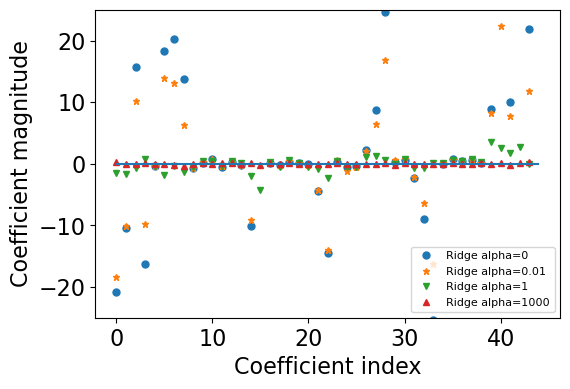

In [8]:
plt.figure(figsize=(6, 4))
markers = ['o','*', 'v','^']
ridge_models = {}
for (i, alpha) in enumerate(alphas):
    r = Ridge(alpha = alpha)
    r.fit(X_train, y_train)
    plt.plot(r.coef_, markers[i], markersize=5, label="Ridge alpha="+ str(alpha))
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(r.coef_))
plt.ylim(-25, 25)
plt.legend(loc="best",fontsize=8);    

Let's try a very large `alpha` value, which is likely to make weights very small. 

In [9]:
ridge10000 = Ridge(alpha=10000).fit(X_train, y_train)
print("Total number of features", X_train.shape[1])
print("Number of non-zero weights: ", np.sum(ridge10000.coef_ != 0))

Total number of features 44
Number of non-zero weights:  44


All features have non-zero weights. 

### Regularization path 

Let's trace the journey of coefficients of a few features with different values of `alpha`. 

In [10]:
feature_names = pf.get_feature_names_out()

Let's examine the coefficients

In [11]:
r10 = Ridge(alpha=0.10)
r10.fit(X_train, y_train)
coefs = (
    pd.DataFrame(r10.coef_, feature_names, columns=["coef"])
    .query("coef != 0")
    .sort_values("coef")
    .reset_index()
    .rename(columns={"index": "variable"})
)

In [12]:
coefs.style.background_gradient('PuOr')

,variable,coef
0,MedInc Longitude,-16.762873
1,MedInc,-10.178537
2,HouseAge Longitude,-9.608717
3,HouseAge,-6.986869
4,MedInc Latitude,-5.683734
5,HouseAge Latitude,-2.931366
6,AveBedrms Longitude,-2.152434
7,AveBedrms Latitude,-1.934514
8,Longitude,-1.637599
9,AveRooms AveBedrms,-1.571689


In [13]:
feats = ['MedInc', 'AveBedrms',  'Population', 'MedInc Longitude', 'Population Longitude', 'Latitude Longitude']

In [14]:
msk = [feat in feats for feat in feature_names]

In [45]:
#feature_names

In [16]:
r10.coef_[msk]

array([-10.17853657,  -0.06709887,  -0.10629543, -16.7628735 ,
         1.19960525,  10.6276393 ])

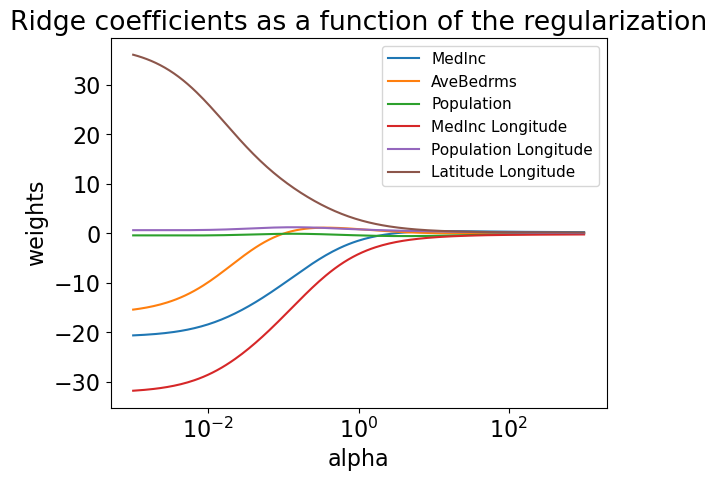

In [17]:
# Attribution: Code adapted from here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_[msk])
    
ax = plt.gca()
ax.plot(alphas, coefs)

ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
ax.legend(feats, loc="best", fontsize=11)
plt.show()

The coefficients are very close to zero but not exactly zero. That said, they won't have much impact on prediction. 

<br><br>

### Regularization learning curves

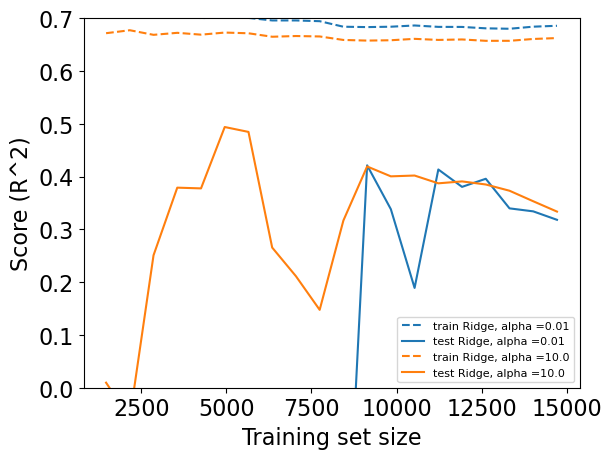

In [18]:
plot_learning_curve(Ridge(alpha=0.01), X_train, y_train)
plot_learning_curve(Ridge(alpha=10.0), X_train, y_train)

- As one would expect, the training score is higher than the test score for all dataset sizes
- Training score of `Ridge` with `alpha=0.01` > Training score of `Ridge` with `alpha=10` (more regularization)
- However, the test score of `Ridge` with `alpha=10` > Test score of `Ridge` with `alpha=0.01` for smaller training sizes. 
- As more and more data becomes available to the model, both models improve. Ridge with less regularization catches up with ridge with more regularization and actually performs better. 

### How to pick $\lambda$? 

- Theory: as $n$ grows $\lambda$ should be in the range $O(1)$ to $\sqrt{n}$.
- Practice: optimize validation set or cross-validation error.
    - Almost always decreases the test error.

### (Optional) Should we regularize the y-intercept?

- No! 
    - Why encourage it to be closer to zero? (It could be anywhere.)
    - You should be allowed to shift function up/down globally.
- Yes! 
    - Useful for optimization; It makes the solution unique and it easier to compute $w$    
- Compromise: regularize by a smaller amount than other variables.
    $$f(w) = \lVert Xw + w_0 - y\rVert^2 + \frac{\lambda_1}{2}\lVert w\rVert^2 + \frac{\lambda_2}{2}w_0^2$$  

### Some properties of L2-regularization

1. Solution $w$ is unique. It has to do with the smoothness of the function. 
    - We are not going into mathematical details. If interested see [slide 20](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L17.pdf) from CPSC 340.
2. **Almost always improves the validation error.** 
3. No collinearity issues.
4. Less sensitive to changes in $X$.
5. Gradient descent (optimization algorithm) converges faster (bigger $\lambda$ means fewer iterations). (You'll learn about Grafient descent in 572.)
6. Worst case: just set $\lambda$ small and get the same performance

### Summary: L2-regularization 

- Change the loss function by adding a continuous L2-penalty on the model complexity. 
- Best parameter $\lambda$ almost already leads to improved validation error.
    - L2-regularized least squares is also called "ridge regression". 
    - Can be solved as a linear system like least squares.
- Some benefits of L2 regularization  
    - Solution is unique.
    - Less sensitive to data.
    - Fast. 

## ❓❓ Questions for you (recap)

### iClicker Exercise 6.1 

**iClicker cloud join link: https://join.iclicker.com/C0P55**

**Select all of the following statements which are TRUE.**

- (A) Introducing L2 regularization to the model means making it less sensitive to changes in $X$.
- (B) Introducing L2 regularization to the model can results in worse performance on the training set. 
- (C) L2 regularization shrinks the weights but all $w_j$s tend to be non-zero.

**V's answers: A, B, C**

### Break (~5 mins)

![](img/eva-coffee.png)


## L1 regularization

- An alternative to `Ridge` (L2-regularization for least squares) is `Lasso`.
- Instead of L0- or L2-norm, regularize with L1-norm. 

$$f(w) = \sum_i^n(w^TX_i - y_i)^2 + \lambda\sum_j^d \lvert w_j \lvert\text{ or }$$ 
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_1$$


- $\lambda \rightarrow$ regularization strength
- $\lVert w\rVert_1 \rightarrow$  L1-norm of $w$  
- Objective balances getting low error vs. having small values for $w_j$


### Similarities with L2-regularization

- L1-regularization 
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_1$$

- L2-regularization 
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_2^2$$

- Both shrink weights.
- Both result in lower validation error. 

**Do not confuse the L1 loss (absolute loss) with L1-regularization!**

### Terminology and notation: Ridge and Lasso

- Linear regression model that uses L2 regularization is called **Ridge** or Tikhonov regularization.
    - [`scikit-learn` Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)
- Linear regression model that uses L1 regularization is called **Lasso**. 
    - [`scikit-learn` Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso)
    > class sklearn.linear_model.Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')



### L1-regularization 

- The consequence of using L1-norm is that some features are exactly zero, which means that the features are entirely ignored by the model. 
- This can be considered as a form of feature selection!! 
- L1-regularization simultaneously regularizes and selects features.
- Very fast alternative to search and score methods

Let's apply `Lasso` on the California housing data. 

In [19]:
X_train.shape

(15480, 44)

In [20]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0


- That's strange. It's not using any features -- like dummy model. It's underfitting. 
- Similar to `Ridge` it also has a regularization hyperparameter `alpha`. 
- Let's decrease it to reduce underfitting. 

- Let's examine weight shrinkage for l1 regularization 
- Lasso loss is not a smooth function. 
- Slower compared to Ridge. 

In [21]:
from numpy.linalg import norm
alphas = [0, 0.0001, 0.01, 0.1, 1]
weight_shrinkage_data = {'alpha':[], '||Xw - y||^2':[], '||w||_1':[], 'intercept':[], 'train score':[], 'test score':[]}

for (i, alpha) in enumerate(alphas): 
    print('alpha: ', alpha)
    l = Lasso(alpha=alpha, max_iter=10000) 
    l.fit(X_train, y_train)
    weight_shrinkage_data['alpha'].append(alpha)
    OLS = np.round(lr_loss_squared(l.coef_, X_train, y_train), 4)
    l1_term = np.round(norm(r.coef_, 1), 4)
    intercept = np.round(l.intercept_, 4)
    weight_shrinkage_data['||Xw - y||^2'].append(OLS)
    weight_shrinkage_data['||w||_1'].append(l1_term)
    weight_shrinkage_data['intercept'].append(intercept)
    weight_shrinkage_data['train score'].append(np.round(l.score(X_train, y_train), 2))
    weight_shrinkage_data['test score'].append(np.round(l.score(X_test, y_test), 2))

alpha:  0


/var/folders/b3/g26r0dcx4b35vf3nk31216hc0000gr/T/ipykernel_27748/2689048393.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  l.fit(X_train, y_train)
/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e+03, tolerance: 2.066e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Ridg

alpha:  0.0001


/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e+03, tolerance: 2.066e+00
  model = cd_fast.enet_coordinate_descent(


alpha:  0.01
alpha:  0.1
alpha:  1


In [22]:
pd.DataFrame(weight_shrinkage_data)

,alpha,||Xw - y||^2,||w||_1,intercept,train score,test score
0,0.0000,73398.6742,4.3674,2.0744,0.67,0.52
1,0.0001,73462.0080,4.3674,2.0744,0.67,0.20
2,0.0100,74463.3147,4.3674,2.0744,0.62,0.33
3,0.1000,76723.2012,4.3674,2.0744,0.51,0.48
4,1.0000,87271.1329,4.3674,2.0744,0.00,-0.00


In [23]:
r = Ridge(alpha = 0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(r.score(X_train, y_train)))
print("Test set score: {:.2f}".format(r.score(X_test, y_test)))
print("Number of features used:", np.sum(r.coef_ != 0))

Training set score: 0.68
Test set score: 0.62
Number of features used: 44


In [24]:
lasso = Lasso(alpha=0.1, max_iter=10000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.51
Test set score: 0.48
Number of features used: 3


- In this case we are not really getting better results with Lasso. 
- In fact, Lasso is not able to do better than linear regression. 
- Often you might see better scores than `Ridge` with fewer features.  
- If `alpha` is too low, we reduce the effect of overfitting and the results are similar to linear regression. 

### The weights become smaller and eventually become zero. 

Let's plot coefficients of `Lasso`. 

In [25]:
alphas = [0, 0.01, 0.1, 1]

/var/folders/b3/g26r0dcx4b35vf3nk31216hc0000gr/T/ipykernel_27748/562400412.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, y_train)
/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e+03, tolerance: 2.066e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

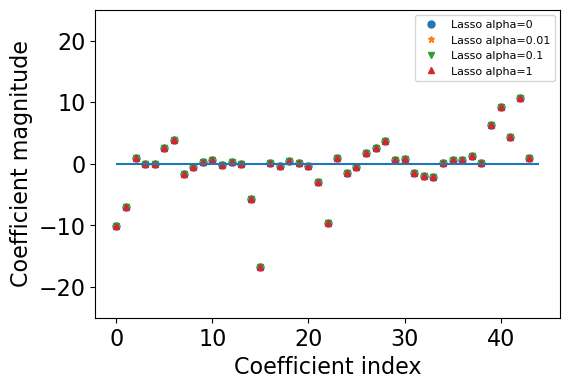

In [26]:
plt.figure(figsize=(6, 4))
markers = ['o','*', 'v','^']
lasso_models = {}
for (i, alpha) in enumerate(alphas):
    lasso = Lasso(alpha = alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    plt.plot(r.coef_, markers[i], markersize=5, label="Lasso alpha="+ str(alpha))
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lasso.coef_))
plt.ylim(-25, 25)
plt.legend(loc="best",fontsize=8);    

- For `alpha = 100` most of the coefficients are zero. 
- With smaller values of `alpha` we get less and less regularization. 

- I'm not showing L1 regularization path on our data because it takes too long to run. 
- But you're likely to see this type of plots in the context of regularization.   
![](img/regularization_paths.png)
<!-- <img src='img/regularization_paths.png' width="1000" height="1000" /> -->

### Terminology and notation: Sparsity 

- We say a linear function is sparse if most of the coefficients are zero. 
- Example: Here only 2 out of 8 coefficients are non-zero and so it is a sparse function. 
$$0x_1 + 0.45 x_2 + 0  x_3 + 0x_4 + 1.2x_5 + 0x_6 + 0x_7 + 0x_8$$
- L0- and L1-regularization encourage sparsity. 

### Example: L0 vs. L1 vs. L2

Consider problem where 3 vectors can get minimum training error:

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- Without regularization, we could choose any of these 3.
- We are assuming that all have the same error, so regularization will "break tie".
- Which one would you choose with each of L0, L1, L2 regularization?

### Which one would you choose with L0 regularization? 

$$w^1 = \begin{bmatrix}100 \\-0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- What are the L0 norms of different weight vectors? 
    - $\lVert w^1\rVert_0 = 2$
    - $\lVert w^2\rVert_0 = 1$
    - $\lVert w^3\rVert_0 = 2$
<br><br><br><br>    
- L0 regularization would choose $w^2$.     

### Which one would you choose with L1 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- What are the L1 norms of different weight vectors?
    - $\lVert w^1\rVert_1 = 100.02$
    - $\lVert w^2\rVert_1 = 100$
    - $\lVert w^3\rVert_1 = 100.01$
    
<br><br><br><br>
- L1-regularization would pick $w^2$
- L1-regularization focuses on decreasing all $w_j$ until they are 0. 

### Which one would you choose with L2 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- What are the L2 norms of different weight vectors?
    - $\lVert w^1\rVert_2^2 = (100)^2 + (0.02)^2 = 10000.0004$
    - $\lVert w^2\rVert_2^2 = (100)^2 = 10000$
    - $\lVert w^3\rVert_2^2 = (99.99)^2 + (0.02)^2 = 9998.0005$

<br><br><br><br>
- L2-regularization would pick $w^3$
- L2-regularization focuses on decreasing largest $w_j$ smaller    

### (Optional) Sparsity and Regularization

- Minimizing $\lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_2^2$ is equivalent to minimizing $\lVert Xw - y\rVert_2^2$ subject to the constraint that $\lVert w\rVert_2^2 \leq t(\delta)$

![](img/regularization_sparsity1.png)

![](img/l1_l2_solution.png)

[Source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L17.pdf)

### Sparsity and Regularization (with d=1) 

![](img/sparsity_regularization.png)
<!-- <img src='img/sparsity_regularization.png' width="1000" height="1000" /> -->

<br><br>

### Some properties of L1 regularization

1. Almost always improves the validation error. 
2. Can learn with exponential number of irrelevant features.
3. Less sensitive to changes in $X$.
4. The solution is not unique. (If interested in more explanation on this, see slide 43 in [this slide deck](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf).)

### Feature selection using L1 regularization 

- Feature selection methods we have seen so far: 
    - RFE
    - Search and score with L0-regularization (e.g., forward search)
- An effective way of feature selection: L1-regularization 

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV

housing = fetch_california_housing(as_frame=True)
X = housing["data"]
y = housing["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe_l1_rf = make_pipeline(
    StandardScaler(),
    SelectFromModel(Lasso(alpha=0.01, max_iter=100000)),
    RandomForestRegressor(),
)

X.shape

(20640, 8)

In [28]:
pipe_l1_rf.fit(X_train, y_train)
pipe_l1_rf.score(X_train, y_train)

0.9731789734697873

In [29]:
print("Training set score: {:.2f}".format(pipe_l1_rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(pipe_l1_rf.score(X_test, y_test)))

Training set score: 0.97
Test set score: 0.79


In [30]:
print(
    "Number of features used:",
    np.sum(pipe_l1_rf.named_steps["selectfrommodel"].estimator_.coef_ != 0),
)

Number of features used: 7


<br><br><br><br>

## Regularized models for classification 

### Regularized logistic regression

- Regularization is not limited to least squares. 
- We can add L1 and L2 penalty terms in other loss functions as well. 
- Let's look at logistic regression with L1- and L2-regularization.

In [31]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
# print(breast_cancer.keys())
# print(breast_cancer.DESCR)

In [32]:
breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["target"] = breast_cancer.target
train_df, test_df = train_test_split(breast_cancer_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [33]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.20,706.7,0.1241,0.22640,0.1326,0.10480,0.2250,0.08321
428,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,11.68,20.29,74.35,421.1,0.1030,0.06219,0.0458,0.04044,0.2383,0.07083
198,19.18,22.49,127.50,1148.0,0.08523,0.14280,0.11140,0.06772,0.1767,0.05529,...,23.36,32.06,166.40,1688.0,0.1322,0.56010,0.3865,0.17080,0.3193,0.09221
203,13.81,23.75,91.56,597.8,0.13230,0.17680,0.15580,0.09176,0.2251,0.07421,...,19.20,41.85,128.50,1153.0,0.2226,0.52090,0.4646,0.20130,0.4432,0.10860
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.1909,0.26980,0.4023,0.14240,0.2964,0.09606


In [34]:
y_train.value_counts(normalize=True)

1    0.632967
0    0.367033
Name: target, dtype: float64

In [35]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(
    f1_score, pos_label=0
)  # note the syntax to change the positive label for f1 score
scoring_metric = custom_scorer

results_classification = {}

Let's try `DummyClassifier`

In [36]:
dummy = DummyClassifier()
results_classification["dummy"] = mean_std_cross_val_scores(
    dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results_classification)

,dummy
fit_time,0.000 (+/- 0.001)
score_time,0.000 (+/- 0.000)
test_score,0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000)


- In `sklearn`, by default logistic regression uses L2 regularization. 
- The `C` hyperparameter decides the strength of regularization. 
- Unfortunately, interpretation of `C` is inverse of `lambda`. 

In [37]:
pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression())
results_classification["Logistic Regression L2"] = mean_std_cross_val_scores(
    pipe_lgr_l2, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [38]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2
fit_time,0.000 (+/- 0.001),0.005 (+/- 0.002)
score_time,0.000 (+/- 0.000),0.001 (+/- 0.000)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005)


Weights are small but all of them are non-zero. 

In [39]:
pipe_lgr_l2.fit(X_train, y_train)
l2_coefs = pipe_lgr_l2.named_steps["logisticregression"].coef_.flatten()
df = pd.DataFrame(l2_coefs, index=X_train.columns, columns=["l2_coefs"])
df

,l2_coefs
mean radius,-0.539854
mean texture,-0.252141
mean perimeter,-0.494560
mean area,-0.610451
mean smoothness,-0.174066
mean compactness,0.577983
mean concavity,-0.658777
mean concave points,-0.980244
mean symmetry,0.119974
mean fractal dimension,0.406479


- Let's try logistic regression with L1 regularization.
- Note that I'm using a different solver (optimizer) here because not all solvers support L1-regularization. 

In [40]:
pipe_lgr_l1 = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", penalty="l1")
)
results_classification["Logistic Regression L1"] = mean_std_cross_val_scores(
    pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [41]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1
fit_time,0.000 (+/- 0.001),0.005 (+/- 0.002),0.003 (+/- 0.001)
score_time,0.000 (+/- 0.000),0.001 (+/- 0.000),0.001 (+/- 0.000)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011),0.967 (+/- 0.007)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005),0.985 (+/- 0.005)


- The scores are more or less the same.

- But L1 regularization is carrying out feature selection; Many coefficients are 0. 
- Similar scores with less features! More interpretable model! 

In [42]:
pipe_lgr_l1.fit(X_train, y_train)
l1_coefs = pipe_lgr_l1.named_steps["logisticregression"].coef_.flatten()
df["l1_coef"] = l1_coefs
df

,l2_coefs,l1_coef
mean radius,-0.539854,0.000000
mean texture,-0.252141,0.000000
mean perimeter,-0.494560,0.000000
mean area,-0.610451,0.000000
mean smoothness,-0.174066,0.000000
mean compactness,0.577983,0.000000
mean concavity,-0.658777,0.000000
mean concave points,-0.980244,-1.337092
mean symmetry,0.119974,0.000000
mean fractal dimension,0.406479,0.271158


We can also carry out feature selection using L1 regularization and pass selected features to another model. 

In [43]:
from lightgbm.sklearn import LGBMClassifier

pipe_lgr_lgbm = make_pipeline(
    StandardScaler(),
    SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1")),
    LGBMClassifier(),
)

In [44]:
results_classification["L1 + LGBM"] = mean_std_cross_val_scores(
    pipe_lgr_lgbm,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1,L1 + LGBM
fit_time,0.000 (+/- 0.001),0.005 (+/- 0.002),0.003 (+/- 0.001),0.151 (+/- 0.015)
score_time,0.000 (+/- 0.000),0.001 (+/- 0.000),0.001 (+/- 0.000),0.001 (+/- 0.000)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011),0.967 (+/- 0.007),0.957 (+/- 0.034)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005),0.985 (+/- 0.005),1.000 (+/- 0.000)


- The score went down a bit this case. But this might help in some other cases.
- The resulting model is using L1 selected features only. 

### How to use regularization with `scikit-learn`: some examples

- Regression
    - Least squares with L2-regularization: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
    - Least squares with L1-regularization: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
    - Least squares with L1- and L2-regularization: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
    - [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR) ($\epsilon$-insensitive loss function)
        - `epsilon = 0` gives us `KernelRidge` model (least squares with RBF)
- Classification 
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (supports L2-regularization)
    - [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (support L1 and L2 with different solvers)
    > penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.



<br><br>

- Interpretations of coefficients of regularized linear models should always be taken with a grain of salt.
- With different values of the regularization parameter, sometimes even the signs of the coefficients might change!!  

![](img/eva-qm.png)

<br><br>

## Regularization: scaling and collinearity 

### Regularization and scaling 

- It doesn't matter for decision trees or naive Bayes.
    - They only look at one feature at a time.
- It doesn't matter for least squares:
    - $w_j*(100 mL)$ gives the same model as $w_j*(0.1 L)$ with a different $w_j$
- It matters for $k$-nearest neighbours:
    - Distance will be affected more by large features than small features.
- **It matters for regularized least squares**:
    - Penalizing $w_j^2$ means different things if features $j$ are on different scales
    - Penalizing $w_j$ means different things if features $j$ are on different scales
    

### Collinearity and regularization 

- If you have colinear features, the weights would go crazy with regular linear regression. 
- With L2 regularization: The weight will be equally distributed among all collinear features because the solution is unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight will be distributed as 1/3, 1/3, 1/3 among the features. 
- With L1 regularization: The weight will not be equally distributed; the solution is not unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight could be distributed in many different ways 
    - For example, 1/2, 1/4, 1/4 or 1.0, 0, 0 or 1/2, 1/2, 0 and so on ...

### Elastic nets

- Combine good properties from both worlds

$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda(\alpha\lVert w\rVert_1 + (1-\alpha)\lVert w\rVert_2^2 )  $$

- $\lambda$ control the strength of regularization 
- $\alpha$ controls the amount of sparsity and smoothness
- L1 promotes sparsity and the L2 promotes smoothness.
- The functional is strictly convex: the solution is unique.
- No collinearity problem 
    - A whole group of correlated variables is selected rather than just one variable in the group.

You can use elastic nets using sklearn's [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). 

## Summary: L* regularization 

- L0-regularization (AIC, BIC, Mallow’s Cp, Adjusted R2, ANOVA): More on this is DSCi 562
   - Adds penalty on the number of non-zeros to select features.

$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_0$$    


- L2-regularization (ridge regression):
    - Adding penalty on the L2-norm of $w$ to decrease overfitting:
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_2^2$$    

- L1-regularization (lasso regression):
    - Adding penalty on the L1-norm decreases overfitting and selects features:
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_1$$            

- Interpretations of coefficients of linear models should always be taken with a grain of salt
    - Regularizing a model might change the sign of the coefficients. 
- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

<br><br><br><br>